# BIOMASS TEAM

### Estimating aboveground biomass from LIDAR at Ordway-Swisher Biological Station (OSBS), Florida, United States

Gaelle Blanvillain, Adam T. Naito, Guillermo Ponce, Christine Swanson, Wubishet Tadesse, Phumudzo Tharaga
 
Using NEON Aerial Observation Platform (AOP) data, we estimated changes in aboveground woody biomass in response to disturbance at Ordway-Swisher Biological Station Specifically, we will focus on a single prescribed burn unit in OSBS to quantify the response in biomass to a prescribed fire in 2015. LIDAR-derived canopy height models (CHMs) generated from AOP flights in 2014 will provide the basis for estimating pre-disturbance biomass, while CHMs generated from AOP flights in 2016 will provide the basis for estimating post-disturbance biomass. One sub-group of three individuals will characterize the 2014 biomass, while the other sub-group will characterize 2016 biomass.


# OUR WORKFLOW

- Data: 
    - AOP-Lidar from OSBS site
    - For training data assumptions were made based on the type of trees to get estimates for DBH, Crown-tree info., etc.
    - GIS layers from the OSBS site
- Method: 
    - We used the Random Forest approach for biomass estimation

In [1]:
# 
import numpy as np
import os
import gdal, osr
import matplotlib.pyplot as plt
import sys 
from scipy import ndimage as ndi
%matplotlib inline

In [2]:
# Import libraries specific to biomass calculations
from skimage.morphology import watershed             # Delineating individual tree crowns
from skimage.feature import peak_local_max           # Calculating predictor variables for all individuals
from skimage.measure import regionprops              # Collecting training data
from sklearn.ensemble import RandomForestRegressor   # Applying a regression model to estiamte biomass from predictors


In [3]:
#Define plot band array function
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.title.set_position([.5, 1.05])
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

## Global variables
Here, you can setup the year you want to process along with the training file to use.

In [4]:
# Set year to process
yr = '2014'

# Set CHM for 2014
chm_file = '2014_CHM_OSBS.tif'

# Set CHM for 2016
#chm_file = '2016_CHM_OSBS.tif'

# Set training file
tr_file = 'pine_training.csv'

# Footprint 
fx = 5
fy = 5

In [5]:
# Open the CHM file with gdal
chm_dataset = gdal.Open(chm_file)

# Get our raster band
chm_raster = chm_dataset.GetRasterBand(1)

# Get No Data Value

noDataVal = chm_raster.GetNoDataValue()

# Get Meta data
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm = chm_dataset.GetGeoTransform()

xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]

xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]

image_extent = (xMin,xMax, yMin, yMax)

### Canopy Height Model (CHM)
Displaying the plot with CHM image

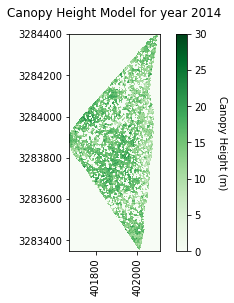

In [6]:
plt.figure(1)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)
plot_band_array(chm_array, image_extent, 'Canopy Height Model for year '+ yr, 'Canopy Height (m)', 'Greens', [0,30])
plt.savefig('Canopy_'+yr+'_OSBS.png',dpi=300,orientation='landscape', \
            bbox_inches='tight',pad_inches=0.1)

## Smoothing process (Gaussian filter)
This process is intended to be used for removing spurious points from the original CHM

In [7]:
# Smooth the CHM using a gaussian filter to remove spurious points
# Parameter 2 = standard deviations 
chm_array_smooth = ndi.gaussian_filter(chm_array,2, mode='constant', truncate=2.0)
# To maintain same structure of the CHM before the smoothing.
chm_array_smooth[chm_array==0]=0

In [8]:
# Save array as raster
array2raster('OSBS_'+yr+'_chm_filter.tif', \
             (xMin,yMax), 1, -1,np.array(chm_array_smooth/10000,dtype=float),32617)


### Calculating local maximum points over the smoothed CHM
Here, the local maximum values are calculated.  During our lesson for San Joaquin site Savanna-Oak we use a footprint of 5,5 in the calculation of the peak local maximum.  For a more dense file we are assuming a lower foot print is required. However, further investigation is required to identify how sensitive is the local max algorithm to the gaussian filter applied.  

The footprint (fx,fy) for the `peak_local_max` is defined in the Global variables section.

In [9]:
#Calculate local maximum points in the smoothed CHM, footprint values for fx,fy are defined in the Global Variables
local_maxi = peak_local_max(chm_array_smooth,indices=False, footprint=np.ones((fx, fy)))

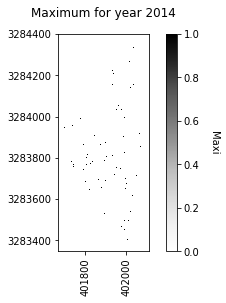

In [10]:
plt.figure(2)
plot_band_array(local_maxi,image_extent, 'Maximum for year '+yr, 'Maxi', 'Greys',[0, 1])
plt.savefig('LocalMaximum_'+yr+'_OSBS_localMax_'+str(fx)+'x'+str(fy)+'.png',dpi=300,orientation='landscape', \
            bbox_inches='tight',pad_inches=0.1)

In [11]:
# Assign unique IDS to all maximum points
markers = ndi.label(local_maxi)[0]


In [12]:
# Create a mask, zero for ground, 1 for trees
chm_mask = chm_array_smooth
chm_mask[chm_array_smooth !=0]=1

In [13]:
# Perform watershed segmentation
labels = watershed(chm_array_smooth, markers, mask=chm_mask)

In [14]:
# Get the properties of tree crowns to collect some 
tree_properties = regionprops(labels,chm_array, \
                              ['Area','BoundingBox', \
                               'Centroid', 'Orientation', \
                               'MajorAxisLength','MinorAxisLength', \
                               'MaxIntensity','MinIntensity'])


In [15]:
#Determine how many trees identified
max_labels = labels.max()
segment_labels = np.zeros(max_labels+1)
segment_id = np.zeros(max_labels+1)

for counter in range(1,max_labels+1):
    segment_labels[counter] = len(labels[labels==counter])
    segment_id[counter]=counter
segment_id = segment_id[np.nonzero(segment_labels)]

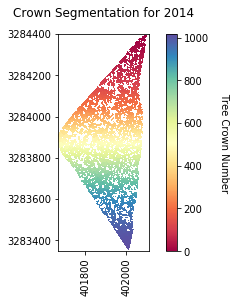

In [16]:
labels = np.array((labels), dtype = float)
#print(labels[np.where(labels > 0.0)])
#import pandas as pd
#df = pd.DataFrame(labels[np.where(labels > 0.0)])
#print(df)

plt.figure(3) 
labels[labels==0] = np.nan

plot_band_array(labels, image_extent, 'Crown Segmentation for '+yr,'Tree Crown Number', \
               'Spectral', [0, max_labels])
array2raster('Labels_OSBS_'+yr+'_chm_filter_LocalMax_'+str(fx)+'x'+str(fy)+'.tif', \
             (xMin,yMax), 1, -1,np.array(labels,dtype=float),32617)

plt.savefig('Segmented_'+yr+'_OSBS_localMax_'+str(fx)+'x'+str(fy)+'.png',dpi=300,orientation='landscape', \
            bbox_inches='tight',pad_inches=0.1)

In [17]:
array2raster(yr+'_OSBS_SegmentedData_LocalMax_'+str(fx)+'x'+str(fy)+'.tif', (xMin,yMax),1, -1, labels, 3261)

In [18]:
# Define predictor variables
area = np.zeros(len(tree_properties))
diameter = np.zeros(len(tree_properties))
max_tree_height = np.zeros(len(tree_properties))
min_tree_height = np.zeros(len(tree_properties))


In [19]:
# Retrieve predictor variables from region props output
for counter in range(0, len(tree_properties)):
    area[counter] = tree_properties[counter]['Area']
    diameter[counter] = tree_properties[counter]['MajorAxisLength']
    max_tree_height[counter] = tree_properties[counter]['MaxIntensity']
    min_tree_height[counter] = tree_properties[counter]['MinIntensity']


In [20]:
# Define remaining predictor variable
crown_geometric_volume_full = np.zeros(len(segment_id))
crown_geometric_volume_50th_percentile = np.zeros(len(segment_id))
crown_geometric_volume_60th_percentile = np.zeros(len(segment_id))
crown_geometric_volume_70th_percentile = np.zeros(len(segment_id))

percentile_50th = np.zeros(len(segment_id))
percentile_60th = np.zeros(len(segment_id))
percentile_70th = np.zeros(len(segment_id))


In [21]:
counter = 0
for segment in segment_id:
    # Pull out the tree of interest
    index_of_tree = np.asarray(np.where(labels==segment)).T
    tree_data = chm_array[index_of_tree[:,0],index_of_tree[:,1]]
    crown_geometric_volume_full[counter] = \
    np.sum([tree_data-np.min(tree_data)])
    
    #50th percentile stats
    percentile_50th[counter] = np.percentile(tree_data,50)
    tree_data_50th = chm_array[index_of_tree[:,0],index_of_tree[:,1]]
    tree_data_50th[tree_data_50th > percentile_50th[counter]] = \
    percentile_50th[counter]
    crown_geometric_volume_50th_percentile[counter]= \
    np.sum([tree_data_50th - min_tree_height[counter]])
    
    #60th percentile stats
    percentile_60th[counter] = np.percentile(tree_data,60)
    tree_data_60th = chm_array[index_of_tree[:,0],index_of_tree[:,1]]
    tree_data_60th[tree_data_60th > percentile_60th[counter]] = \
    percentile_60th[counter]
    crown_geometric_volume_60th_percentile[counter]= \
    np.sum([tree_data_60th - min_tree_height[counter]])
    
    #50th percentile stats
    percentile_70th[counter] = np.percentile(tree_data,70)
    tree_data_70th = chm_array[index_of_tree[:,0],index_of_tree[:,1]]
    tree_data_70th[tree_data_70th > percentile_70th[counter]] = \
    percentile_70th[counter]
    crown_geometric_volume_70th_percentile[counter]= \
    np.sum([tree_data_70th - min_tree_height[counter]])  
    
    counter = counter + 1

In [22]:
# Get the training
#Define the file of training data  
training_data_file = tr_file

#Read in the training data from a CSV file
training_data = np.genfromtxt(training_data_file,delimiter=',') 

#Grab the biomass (Y) from the first line
biomass = training_data[:,0]

#Grab the biomass prdeictors from the remaining lines
biomass_predictors = training_data[:,1:12]

In [23]:
#Define paraemters for Random forest regressor
max_depth = 30

#Define regressor rules
regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)

#Fit the biomass to regressor variables
regr_rf.fit(biomass_predictors,biomass)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

In [24]:
#Stack the predictor variables for all the individual trees
all_training_data = np.stack([area,diameter,max_tree_height,\
                              min_tree_height,percentile_50th,\
                              percentile_60th,percentile_70th,\
                              crown_geometric_volume_full,\
                              crown_geometric_volume_50th_percentile,\
                              crown_geometric_volume_60th_percentile,\
                              crown_geometric_volume_70th_percentile],\
                              axis=-1)


In [25]:
#Apply the model to the 
pred_biomass = regr_rf.predict(all_training_data)

In [26]:
#Set an out raster with the same size as the labels
biomass_out = labels

#Set counter to zero
counter = 0
#Assign each tree by the associated biomass
for segment in segment_id:
    biomass_out[biomass_out==segment] = pred_biomass[counter]
    counter = counter+1

Sum of biomass for yr 2014: 260317.61 kg


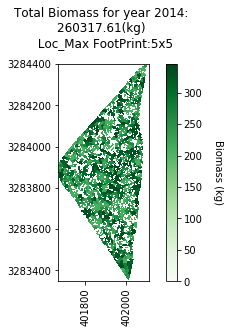

In [27]:
#Get biomass stats for plotting
mean_biomass = np.mean(pred_biomass)
std_biomass = np.std(pred_biomass)
min_biomass = np.min(pred_biomass)
sum_biomass = np.sum(pred_biomass)

print('Sum of biomass for yr '+yr+': '+str(round(sum_biomass,2)),'kg')

#Plot the biomass!
plt.figure(5)
plot_band_array(biomass_out,image_extent,'Total Biomass for year '+yr+': \n'+ \
                str(round(sum_biomass,2))+ '(kg) \n Loc_Max FootPrint:'+str(fx)+'x'+str(fy),\
                'Biomass (kg)','Greens',[0, mean_biomass+std_biomass*2])
                #'Biomass (kg)','YlGn',[0,350])
plt.savefig('Biomass_'+yr+'_OSBS_LocalMax_'+str(fx)+'x'+str(fy)+'.png',\
            dpi=300,orientation='landscape', \
            bbox_inches='tight',pad_inches=0.1)